# End-to-end Masked Language Modeling with BERT

**Author:** [Ankur Singh](https://twitter.com/ankur310794)<br>
**Date created:** 2020/09/18<br>
**Last modified:** 2020/09/18<br>
**Description:** Implement a Masked Language Model (MLM) with BERT and fine-tune it on the Trip Advisor Hotel Reviews dataset.

## Introduccion

"Masked Language Modeling" (Modelado de Lenguaje Enmascarado). El Modelado de Lenguaje Enmascarado es una tarea de rellenar espacios en blanco, en la cual un modelo utiliza las palabras de contexto que rodean un token enmascarado para intentar predecir cuál debería ser la palabra enmascarada.

Para una entrada que contiene uno o más tokens enmascarados, el modelo generará la sustitución más probable para cada uno.

Se presenta un ejemplo para ilustrar esto:

- Entrada: "I have watched this [MASK] and it was awesome."
- Salida: "I have watched this movie and it was awesome."

El modelado de lenguaje enmascarado es una excelente manera de entrenar un modelo de lenguaje en un entorno auto-supervisado (sin etiquetas anotadas por humanos). Luego, se puede ajustar este modelo para realizar varias tareas de procesamiento de lenguaje natural supervisadas.

Este ejemplo te enseña cómo construir un modelo BERT desde cero, entrenarlo con la tarea de modelado de lenguaje enmascarado y luego ajustar este modelo en una tarea de clasificación de sentimientos.

Se utilizarán las capas de TextVectorization y MultiHeadAttention de Keras para crear una arquitectura de red de BERT Transformer-Encoder.

Nota: Este ejemplo debe ejecutarse con tf-nightly (una versión específica de TensorFlow).

**TOKENIZACION BERT**


---



BERT utiliza un enfoque de tokenización llamado WordPiece tokenization para dividir el texto en unidades más pequeñas llamadas "tokens".

El texto se divide inicialmente en palabras individuales. Por ejemplo, la frase "Hola, ¿cómo estás?" se divide en las palabras: ["Hola", ",", "¿cómo", "estás", "?"].

Luego, cada palabra se descompone en subunidades más pequeñas utilizando el algoritmo de WordPiece. Esto implica dividir la palabra en partes más pequeñas y agregar un símbolo especial "[##]" al principio de cada subunidad, excepto la primera. Por ejemplo, la palabra "estás" se descompone en ["es", "##tás"].

Después de la descomposición, todas las subunidades (incluidas las palabras originales y las subunidades generadas) se consideran tokens individuales. Por lo tanto, los tokens resultantes de la frase original serían: ["Hola", ",", "¿", "cómo", "es", "##tás", "?"].

Además, se agregan dos tokens especiales al principio y final del texto: [CLS] (representa el inicio del texto) y [SEP] (marca el final del texto o separa diferentes segmentos de texto en el caso de oraciones múltiples).

WordPiece es el algoritmo de tokenización de subpalabras utilizado para BERT , DistilBERT y Electra . El algoritmo se describió en la búsqueda por voz en japonés y coreano (Schuster et al., 2012) y es muy similar a BPE. WordPiece primero inicializa el vocabulario para incluir todos los caracteres presentes en los datos de entrenamiento y aprende progresivamente un número determinado de reglas de combinación. A diferencia de BPE, WordPiece no elige el par de símbolos más frecuente, sino el que maximiza la probabilidad de los datos de entrenamiento una vez agregados al vocabulario.

Entonces, ¿qué significa esto exactamente? Haciendo referencia al ejemplo anterior, maximizar la probabilidad de los datos de entrenamiento es equivalente a encontrar el par de símbolos, cuya probabilidad dividida por las probabilidades de su primer símbolo seguido por su segundo símbolo es la mayor entre todos los pares de símbolos. Por ejemplo "u" , seguido de "g"solo se habría fusionado si la probabilidad de "ug"dividirse por "u"hubiera "g"sido mayor que para cualquier otro par de símbolos. Intuitivamente, WordPiece es ligeramente diferente a BPE en el sentido de que evalúa lo que pierde fusionando dos símbolos para asegurarse de que vale la pena .

Al reducir las palabras en subunidades utilizando WordPiece en BERT, se puede manejar el problema de las palabras raras o fuera de vocabulario que no se encuentran en el vocabulario original. Al dividir las palabras en subunidades de caracteres y fusionar iterativamente las secuencias de caracteres más frecuentes, se pueden representar de manera más efectiva las palabras que no se encuentran en el vocabulario inicial. Entonces, aunque técnicamente las palabras reducidas en subunidades se encuentran en el vocabulario, lo importante es que se pueden representar y entender mejor por el modelo BERT gracias a la segmentación de subpalabras.

WordPiece es una técnica de tokenización utilizada en BERT y otros modelos de procesamiento de lenguaje natural. Su objetivo principal es dividir el texto en unidades más pequeñas, llamadas subword tokens, para mejorar la cobertura y tratar con palabras poco frecuentes o desconocidas.

A continuación, te explicaré cómo funciona la tokenización WordPiece en BERT:

Vocabulario: BERT utiliza un vocabulario predefinido que contiene una lista de palabras y subword tokens que se utilizarán durante el procesamiento del texto. Este vocabulario generalmente incluye palabras comunes y también subword tokens especiales, como [UNK] (desconocido), [CLS] (inicio de secuencia), [SEP] (separador), entre otros.

Tokenización: Durante el proceso de tokenización, el texto se divide en subword tokens utilizando el vocabulario de WordPiece. La tokenización se realiza de manera iterativa y busca la subdivisión óptima de las palabras en subword tokens. Si una palabra del texto se encuentra en el vocabulario, se divide en subword tokens. Si una palabra no está presente en el vocabulario, se divide en subword tokens más pequeños o se reemplaza por el subword token [UNK].

Subword Tokens: Los subword tokens son fragmentos más pequeños de palabras o caracteres que se utilizan para representar el texto. Estos subword tokens pueden ser partes de palabras, prefijos, sufijos o caracteres individuales. Por ejemplo, la palabra "unhappy" podría dividirse en los subword tokens "un", "##h", "##ap", "##py".

Añadiendo Tokens Especiales: Además de los subword tokens resultantes de la división de palabras, se agregan tokens especiales al principio y al final del texto. Estos tokens especiales incluyen [CLS] al inicio para indicar el inicio de una secuencia y [SEP] al final para indicar el final de una secuencia. También se pueden agregar otros tokens especiales según la tarea o el modelo en particular.

La tokenización WordPiece permite que BERT maneje palabras poco frecuentes o desconocidas, ya que puede dividirlas en subword tokens más comunes que están presentes en el vocabulario. Además, la tokenización en subword tokens ayuda a capturar información más fina en el nivel de las unidades más pequeñas, lo que mejora el rendimiento del modelo en tareas de lenguaje natural.

**BERT EMBEDDINGS**


---



Los embeddings en BERT capturan las relaciones contextuales entre las palabras en una oración o texto. Estas relaciones contextuales se refieren a cómo una palabra se relaciona con las palabras vecinas y cómo su significado puede cambiar según el contexto en el que aparece.

Cada token en una oración tiene su propio embedding, que es un vector numérico de alta dimensionalidad. Estos embeddings se calculan mediante el análisis del contexto en el que aparecen las palabras durante el entrenamiento de BERT.

Cuando BERT procesa una oración, examina las palabras vecinas de cada token y captura patrones y relaciones sintácticas y semánticas. Estos patrones y relaciones se reflejan en los embeddings correspondientes.

Por ejemplo, en la oración "El gato está durmiendo en la alfombra", el embedding del token "gato" capturará información contextual sobre cómo "gato" se relaciona con las palabras vecinas "El" y "está durmiendo en la alfombra". Esto ayudará a BERT a comprender que "gato" se refiere a un animal doméstico y no a otra cosa.

Los embeddings en BERT se actualizan a medida que se procesa la secuencia de tokens, incorporando la información contextual de las palabras anteriores y posteriores en la oración.

En resumen, los embeddings en BERT representan las relaciones contextuales entre las palabras en una oración o texto, y estos embeddings permiten a BERT comprender y capturar el significado de las palabras en función del contexto en el que aparecen.

El feed-forward neural network (FFN) se utiliza en el modelo Transformer con el fin de agregar capacidades de modelado no lineal a la arquitectura. En el contexto de las redes neuronales y el procesamiento de información, la no linealidad se refiere a la capacidad de capturar y modelar relaciones complejas y no lineales entre las variables de entrada y salida.

En contraste, las relaciones lineales se pueden representar mediante operaciones lineales, como multiplicaciones y sumas. Estas relaciones lineales son simples y limitadas en su capacidad para capturar la complejidad de muchos problemas del mundo real.

La no linealidad permite a las redes neuronales modelar relaciones más complejas y no lineales entre las variables. Introduce funciones de activación no lineales, como la función ReLU (Rectified Linear Unit) o la función sigmoide, que se aplican a las salidas de las capas para introducir no linealidades en el modelo.

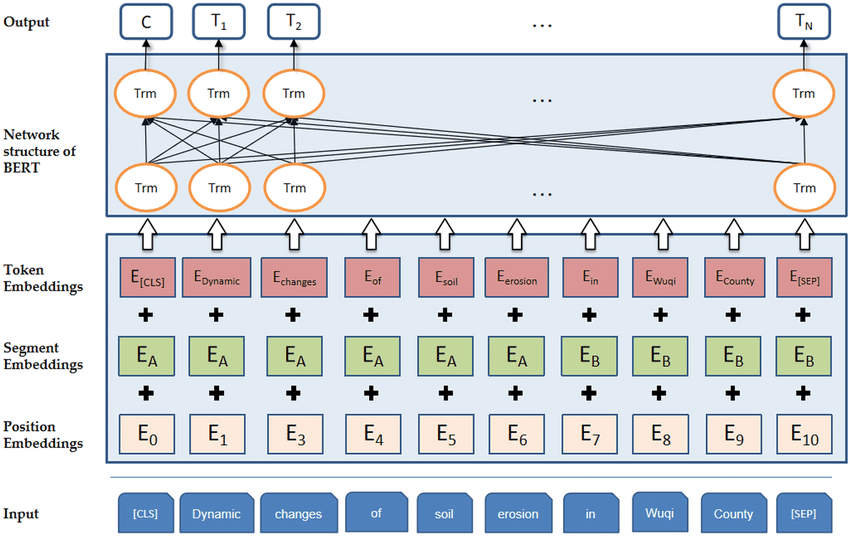

**BERT TRANSFORMERS**


---



Un Transformer es una arquitectura de red neuronal utilizada en modelos de procesamiento de lenguaje natural, como BERT. Su objetivo principal es capturar las relaciones y dependencias entre las palabras en un texto.

Imagina que tienes una oración: "El gato está durmiendo". Queremos entender el significado de la oración y extraer información de ella. Aquí es donde entra en juego el Transformer.

El Transformer procesa la oración en forma de tokens. En este caso, cada palabra de la oración sería un token: "El", "gato", "está" y "durmiendo". Cada uno de estos tokens se representa mediante un vector numérico llamado embedding, que captura su significado y características.

El Transformer toma estos embeddings de los tokens y los procesa en dos pasos principales: la etapa de codificación y la etapa de decodificación.

En la etapa de codificación, el Transformer examina cada token y lo combina con la información contextual de los tokens vecinos. Esto se hace mediante un mecanismo llamado atención (attention), que permite al modelo enfocarse en diferentes partes del texto para capturar las relaciones entre las palabras. El Transformer calcula los pesos de atención para cada par de tokens y utiliza estos pesos para actualizar las representaciones de los tokens.

En nuestro ejemplo, el Transformer se enfocaría en cada palabra y la relacionaría con las palabras vecinas, considerando su orden y contexto. Por ejemplo, el Transformer podría notar que "gato" y "durmiendo" están relacionados y que "está" indica una acción en progreso.

Una vez que la etapa de codificación ha capturado la información contextual de los tokens, la etapa de decodificación permite utilizar esta información para realizar tareas específicas, como clasificación de sentimientos, respuesta a preguntas, generación de texto, entre otras. En esta etapa, el Transformer toma las representaciones de los tokens codificados y las procesa adicionalmente para obtener la salida deseada.

 Un Transformer, `el mecanismo de atención` se basa en el concepto de pares de tokens y calcula la importancia o relevancia de cada token en relación con otros tokens en el contexto de una tarea dada.

Cuando se habla de pares de tokens, se refiere a cada combinación posible de dos tokens en una secuencia. Para una oración de longitud N, hay N * N pares de tokens posibles.

`El cálculo de la atención se realiza en tres etapas principales:`

- Preparación de consultas, claves y valores: Cada token de la secuencia se transforma en tres vectores diferentes: consulta (query), clave (key) y valor (value). Estos vectores se utilizan para calcular la relevancia entre los tokens.

- Cálculo de la similitud: Para cada par de tokens, se calcula la similitud o compatibilidad entre la consulta y la clave correspondiente. Esto se hace mediante el producto punto entre los vectores de consulta y clave, seguido de una normalización.

- Pesos de atención y combinación: La similitud calculada se utiliza para asignar pesos de atención a cada par de tokens. Estos pesos indican la importancia relativa de cada token en relación con los demás. Luego, los valores se multiplican por los pesos de atención y se suman para obtener una representación ponderada de los valores originales.

En términos más sencillos, el mecanismo de atención permite al modelo dar más importancia a ciertos tokens en función de su relevancia en el contexto. Se basa en la comparación de cada par de tokens para determinar qué tokens son más relevantes para comprender el significado de la oración.

Por ejemplo, en la oración "El gato está durmiendo", el mecanismo de atención podría prestar más atención a los pares "gato-durmiendo" y "está-durmiendo" para capturar la relación entre el sujeto y la acción.

Es importante tener en cuenta que el mecanismo de atención en un Transformer se aprende durante el entrenamiento del modelo. Durante el entrenamiento, el modelo ajusta los pesos y parámetros para calcular la atención de manera óptima y capturar las relaciones importantes en el texto.


- Consultas (Queries): Las consultas son los vectores de representación utilizados para calcular la relevancia entre los tokens en el mecanismo de atención. Cada token en la secuencia se transforma en un vector de consulta. Las consultas se utilizan para buscar información relevante en los tokens de clave.

- Claves (Keys): Las claves también son vectores de representación asociados a cada token en la secuencia. Las claves se utilizan para calcular la similitud o compatibilidad entre las consultas y las claves correspondientes.` La similitud entre una consulta y una clave indica la relevancia o importancia relativa de un token en relación con otros tokens en el contexto.`

- Valores (Values): Los valores son los vectores de representación originales asociados a cada token en la secuencia. Representan la información contenida en cada token. Los valores se utilizan para construir una representación ponderada en función de los pesos de atención calculados.

`Importante enteder`

El mecanismo de atención en BERT, conocido como la atención de "self-attention" o "multi-head attention", permite al modelo capturar las relaciones contextuales entre los tokens en una secuencia.

En BERT, se utiliza una variante específica de la atención conocida como "self-attention" o "multi-head attention". Este mecanismo de atención opera en tres pasos principales:

- Proyección lineal: Cada token en la secuencia de entrada se proyecta linealmente en tres representaciones: consultas (queries), claves (keys) y valores (values). Estas proyecciones se realizan para capturar diferentes aspectos de la información de cada token.

- Cálculo de puntuaciones de atención: Se calculan las puntuaciones de atención entre todas las parejas posibles de tokens en la secuencia. Esto se logra mediante productos escalares entre las consultas y las claves correspondientes. Estas puntuaciones de atención cuantifican la relevancia entre los tokens.

- Ponderación y combinación: Las puntuaciones de atención se utilizan para ponderar los valores de los tokens. Cuanto mayor sea la puntuación de atención entre dos tokens, mayor será la importancia de los valores asociados a esos tokens en la representación contextualizada resultante. Los valores ponderados se combinan y se generan las representaciones contextualizadas de los tokens.

Este proceso de atención se repite varias veces en BERT utilizando múltiples "cabezas de atención" (multi-head attention) para capturar diferentes tipos de relaciones y patrones en los datos. Cada cabeza de atención tiene sus propias proyecciones lineales y calcula sus propias puntuaciones de atención, lo que permite al modelo capturar una amplia gama de relaciones contextuales.

## Importaciones

Install `tf-nightly` via `pip install tf-nightly`.

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from dataclasses import dataclass
import pandas as pd
import numpy as np
import glob
import re
from pprint import pprint

## Configuración Parametros

In [11]:

@dataclass
class Config:
    MAX_LEN = 256
    BATCH_SIZE = 32
    LR = 0.001
    VOCAB_SIZE = 30000
    EMBED_DIM = 128
    NUM_HEAD = 8  # used in bert model
    FF_DIM = 128  # used in bert model
    NUM_LAYERS = 1


config = Config()

## Cargar Dataset

We will first download the hoteles data and load into a Pandas dataframe.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
ruta_archivo = '/content/drive/MyDrive/tripadvisor_hotel_reviews.rar'


In [ ]:
!apt-get install unrar


In [12]:
ruta_destino = '/content/drive/MyDrive/dataset_modeloBert/'
!unrar x {ruta_archivo} {ruta_destino}

# !curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
# !tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  9921k      0  0:00:08  0:00:08 --:--:-- 16.1M


In [13]:


def get_text_list_from_files(files):
    # Crea una lista vacía para almacenar el texto de los archivos
    text_list = []
    for name in files:
        # Abre cada archivo en modo lectura
        with open(name) as f:
            for line in f:
                # Agrega cada línea del archivo a la lista de texto
                text_list.append(line)
    return text_list

def get_data_from_text_files(folder_name):
    # Obtiene la lista de archivos de texto de la carpeta correspondiente
    pos_files = glob.glob("aclImdb/" + folder_name + "/pos/*.txt")
    # Obtiene el texto de los archivos y los almacena en una lista
    pos_texts = get_text_list_from_files(pos_files)
    # Obtiene la lista de archivos de texto de la carpeta correspondiente
    neg_files = glob.glob("aclImdb/" + folder_name + "/neg/*.txt")
    # Obtiene el texto de los archivos y los almacena en una lista
    neg_texts = get_text_list_from_files(neg_files)

    # Crea un DataFrame de pandas para almacenar los datos
    # Combina las reseñas positivas y negativas en una sola columna "review"
    # Asigna la etiqueta de sentimiento "0" para las reseñas positivas y "1" para las negativas
    df = pd.DataFrame(
        {
            "review": pos_texts + neg_texts,
            "sentiment": [0] * len(pos_texts) + [1] * len(neg_texts),
        }
    )

    # Mezcla aleatoriamente el DataFrame
    df = df.sample(len(df)).reset_index(drop=True)
    return df

# Obtiene el conjunto de datos de entrenamiento y de prueba
train_df = get_data_from_text_files("train")
test_df = get_data_from_text_files("test")

# Combina los conjuntos de datos de entrenamiento y prueba en uno solo
all_data = train_df.append(test_df)

<ipython-input-13-8ceaa8b3c06e>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_data = train_df.append(test_df)


## Preparar Dataset

Utilizaremos la capa de `TextVectorization` para vectorizar el texto en identificadores de tokens enteros. Transforma un lote de cadenas en una secuencia de índices de tokens (una muestra = una matriz unidimensional de índices de tokens enteros, en orden) o en una representación densa (una muestra = una matriz unidimensional de valores en punto flotante que codifican un conjunto desordenado de tokens).

A continuación, definimos 3 funciones de preprocesamiento:

1.  La función `get_vectorize_layer` construye la capa de `TextVectorization`.
2.  La función `encode` codifica el texto sin procesar en identificadores de tokens enteros.
3.  La función `get_masked_input_and_labels` enmascara los identificadores de tokens de entrada. Enmascara aleatoriamente el 15% de todos los tokens de entrada en cada secuencia.

In [14]:
def custom_standardization(input_data):
    # Convierte el texto a minúsculas
    lowercase = tf.strings.lower(input_data)
    # Elimina etiquetas HTML como "<br />" y las reemplaza por un espacio en blanco
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    # Elimina caracteres especiales utilizando una expresión regular
    return tf.strings.regex_replace(
        stripped_html, "[%s]" % re.escape("!#$%&'()*+,-./:;<=>?@\^_`{|}~"), ""
    )


def get_vectorize_layer(texts, vocab_size, max_seq, special_tokens=["[MASK]"]):
    """Construye una capa de vectorización de texto.

    Args:
      texts (list): Lista de textos de entrada.
      vocab_size (int): Tamaño del vocabulario.
      max_seq (int): Longitud máxima de la secuencia.
      special_tokens (list, opcional): Lista de tokens especiales. Por defecto es ['[MASK]'].

    Returns:
        layers.Layer: Retorna la capa de vectorización de texto de Keras.
    """
    vectorize_layer = TextVectorization(
        max_tokens=vocab_size,
        output_mode="int",
        standardize=custom_standardization,
        output_sequence_length=max_seq,
    )
    vectorize_layer.adapt(texts)

    # Inserta el token de máscara en el vocabulario
    vocab = vectorize_layer.get_vocabulary()
    vocab = vocab[2 : vocab_size - len(special_tokens)] + ["[mask]"]
    vectorize_layer.set_vocabulary(vocab)
    return vectorize_layer


vectorize_layer = get_vectorize_layer(
    all_data.review.values.tolist(),
    config.VOCAB_SIZE,
    config.MAX_LEN,
    special_tokens=["[mask]"],
)

# Obtiene el ID del token de máscara para el modelo de lenguaje enmascarado
mask_token_id = vectorize_layer(["[mask]"]).numpy()[0][0]


def encode(texts):
    encoded_texts = vectorize_layer(texts)
    return encoded_texts.numpy()


def get_masked_input_and_labels(encoded_texts):
    # Se enmascara el 15% de los tokens de BERT
    inp_mask = np.random.rand(*encoded_texts.shape) < 0.15
    # No se enmascaran los tokens especiales

    inp_mask[encoded_texts <= 2] = False
    # Se establecen los objetivos en -1 por defecto, lo que significa ignorarlosdd
    labels = -1 * np.ones(encoded_texts.shape, dtype=int)
    # Se establecen las etiquetas para los tokens enmascarados
    labels[inp_mask] = encoded_texts[inp_mask]

    # Preparación de la entrada
    encoded_texts_masked = np.copy(encoded_texts)
    # Se establece la entrada como [MASK] que es el último token para el 90% de los tokens
    # Esto significa que el 10% se mantiene sin cambios
    inp_mask_2mask = inp_mask & (np.random.rand(*encoded_texts.shape) < 0.90)
    encoded_texts_masked[
        inp_mask_2mask
    ] = mask_token_id  # El token de máscara es el último en el diccionario

    # Se establece el 10% a un token aleatorio
    inp_mask_2random = inp_mask_2mask & (np.random.rand(*encoded_texts.shape) < 1 / 9)
    encoded_texts_masked[inp_mask_2random] = np.random.randint(
        3, mask_token_id, inp_mask_2random.sum()
    )

    # Preparación de los pesos de muestra para pasar al método .fit()
    sample_weights = np.ones(labels.shape)
    sample_weights[labels == -1] = 0

    # Las etiquetas y_labels serán iguales a los tokens de entrada codificados
    y_labels = np.copy(encoded_texts)

    return encoded_texts_masked, y_labels, sample_weights


# Tenemos 25000 ejemplos para el entrenamiento
x_train = encode(train_df.review.values)  # Codifica las reseñas con el vectorizador
y_train = train_df.sentiment.values
train_classifier_ds = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(1000)
    .batch(config.BATCH_SIZE)
)

# Tenemos 25000 ejemplos para la prueba
x_test = encode(test_df.review.values)
y_test = test_df.sentiment.values
test_classifier_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(
    config.BATCH_SIZE
)

# Construye el conjunto de datos de entrada para el modelo de extremo a extremo (se utilizará al final)
test_raw_classifier_ds = tf.data.Dataset.from_tensor_slices(
    (test_df.review.values, y_test)
).batch(config.BATCH_SIZE)

# Preparación de los datos para el modelo de lenguaje enmascarado
x_all_review = encode(all_data.review.values)
x_masked_train, y_masked_labels, sample_weights = get_masked_input_and_labels(
    x_all_review
)

mlm_ds = tf.data.Dataset.from_tensor_slices(
    (x_masked_train, y_masked_labels, sample_weights)
)
mlm_ds = mlm_ds.shuffle(1000).batch(config.BATCH_SIZE)

## Crear un modelo BERT (Modelo de Preentrenamiento(Transferlerning)) para el modelado de lenguaje con máscara.

Crearemos una arquitectura de modelo de preentrenamiento similar a BERT utilizando la capa MultiHeadAttention. Tomará identificadores de tokens como entrada (incluyendo los tokens enmascarados) y predecirá los identificadores correctos para los tokens enmascarados de entrada.

In [15]:
#  implementa un módulo de atención propia multi-cabeza seguido de capas de dropout y normalización.
#  Recibe una consulta (query), una clave (key) y un valor (value) y realiza la atención propia multi-cabeza sobre ellos.
#  Luego, aplica dropout, normalización y una capa feed-forward para obtener la salida del módulo.
def bert_module(query, key, value, i):
    # Multi headed self-attention
    attention_output = layers.MultiHeadAttention(
        num_heads=config.NUM_HEAD,
        key_dim=config.EMBED_DIM // config.NUM_HEAD,
        name="encoder_{}/multiheadattention".format(i),
    )(query, key, value)
    attention_output = layers.Dropout(0.1, name="encoder_{}/att_dropout".format(i))(
        attention_output
    )
    attention_output = layers.LayerNormalization(
        epsilon=1e-6, name="encoder_{}/att_layernormalization".format(i)
    )(query + attention_output)

    # Feed-forward layer
    ffn = keras.Sequential(
        [
            layers.Dense(config.FF_DIM, activation="relu"),
            layers.Dense(config.EMBED_DIM),
        ],
        name="encoder_{}/ffn".format(i),
    )
    ffn_output = ffn(attention_output)
    ffn_output = layers.Dropout(0.1, name="encoder_{}/ffn_dropout".format(i))(
        ffn_output
    )
    sequence_output = layers.LayerNormalization(
        epsilon=1e-6, name="encoder_{}/ffn_layernormalization".format(i)
    )(attention_output + ffn_output)
    return sequence_output

# genera una matriz de codificación de posición utilizada para agregar información de posición a los embeddings de los tokens.
# La matriz se calcula utilizando funciones sinusoidales y cosinusoidales y se utiliza para codificar la posición de los tokens en la secuencia.

def get_pos_encoding_matrix(max_len, d_emb):
    pos_enc = np.array(
        [
            [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)]
            if pos != 0
            else np.zeros(d_emb)
            for pos in range(max_len)
        ]
    )
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2])  # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2])  # dim 2i+1
    return pos_enc

# loss_fn es una instancia de la función de pérdida SparseCategoricalCrossentropy,
# que se utilizará para calcular la pérdida durante el entrenamiento del modelo.

loss_fn = keras.losses.SparseCategoricalCrossentropy(
    reduction=tf.keras.losses.Reduction.NONE
)
#  métrica que realiza un seguimiento de la pérdida promedio durante el entrenamiento.
loss_tracker = tf.keras.metrics.Mean(name="loss")

# Calcula las predicciones, la pérdida y los gradientes, actualiza los pesos y realiza un seguimiento de la pérdida promedio.
class MaskedLanguageModel(tf.keras.Model):
    def train_step(self, inputs):
        if len(inputs) == 3:
            features, labels, sample_weight = inputs
        else:
            features, labels = inputs
            sample_weight = None

        with tf.GradientTape() as tape:
            predictions = self(features, training=True)
            loss = loss_fn(labels, predictions, sample_weight=sample_weight)

        # Calcular los gradientes
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Actualizar los pesos
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Calcular nuestras propias métricas
        loss_tracker.update_state(loss, sample_weight=sample_weight)

        # Devolver un diccionario que mapee los nombres de las métricas a los valores actuales
        return {"loss": loss_tracker.result()}

    @property
    def metrics(self):
        # Listamos nuestros objetos `Metric` aquí para que `reset_states()`
        # se llame automáticamente al comienzo de cada época
        # o al comienzo de `evaluate()`.
        # Si no implementas esta propiedad, debes llamar a `reset_states()` tú mismo en el momento que elijas.
        return [loss_tracker]

#  función que crea y compila el modelo MLM de BERT. Define la arquitectura del modelo utilizando capas de entrada,
#   embeddings, módulos BERT y una capa densa de salida para la clasificación de palabras enmascaradas.
def create_masked_language_bert_model():
    inputs = layers.Input((config.MAX_LEN,), dtype=tf.int64)

    word_embeddings = layers.Embedding(
        config.VOCAB_SIZE, config.EMBED_DIM, name="word_embedding"
    )(inputs)
    position_embeddings = layers.Embedding(
        input_dim=config.MAX_LEN,
        output_dim=config.EMBED_DIM,
        weights=[get_pos_encoding_matrix(config.MAX_LEN, config.EMBED_DIM)],
        name="position_embedding",
    )(tf.range(start=0, limit=config.MAX_LEN, delta=1))
    embeddings = word_embeddings + position_embeddings

    encoder_output = embeddings
    for i in range(config.NUM_LAYERS):
        encoder_output = bert_module(encoder_output, encoder_output, encoder_output, i)

    mlm_output = layers.Dense(config.VOCAB_SIZE, name="mlm_cls", activation="softmax")(
        encoder_output
    )
    mlm_model = MaskedLanguageModel(inputs, mlm_output, name="masked_bert_model")

    optimizer = keras.optimizers.Adam(learning_rate=config.LR)
    mlm_model.compile(optimizer=optimizer)
    return mlm_model

# son diccionarios que mapean los identificadores de tokens a palabras y viceversa.

id2token = dict(enumerate(vectorize_layer.get_vocabulary()))
token2id = {y: x for x, y in id2token.items()}


# es una clase de devolución de llamada de Keras que se utiliza para generar texto enmascarado durante
# el entrenamiento del modelo. En el método on_epoch_end, se utilizan las predicciones del modelo para
# reemplazar los tokens enmascarados por las palabras más probables y se muestra el resultado
class MaskedTextGenerator(keras.callbacks.Callback):
    def __init__(self, sample_tokens, top_k=5):
        self.sample_tokens = sample_tokens
        self.k = top_k

    def decode(self, tokens):
        return " ".join([id2token[t] for t in tokens if t != 0])

    def convert_ids_to_tokens(self, id):
        return id2token[id]

    def on_epoch_end(self, epoch, logs=None):
        prediction = self.model.predict(self.sample_tokens)

        masked_index = np.where(self.sample_tokens == mask_token_id)
        masked_index = masked_index[1]
        mask_prediction = prediction[0][masked_index]

        top_indices = mask_prediction[0].argsort()[-self.k :][::-1]
        values = mask_prediction[0][top_indices]

        for i in range(len(top_indices)):
            p = top_indices[i]
            v = values[i]
            tokens = np.copy(sample_tokens[0])
            tokens[masked_index[0]] = p
            result = {
                "input_text": self.decode(sample_tokens[0].numpy()),
                "prediction": self.decode(tokens),
                "probability": v,
                "predicted mask token": self.convert_ids_to_tokens(p),
            }
            pprint(result)

# sample_tokens es una matriz de tokens enmascarados utilizada para generar texto enmascarado
# durante el entrenamiento. Se utiliza en la devolución de llamada MaskedTextGenerator.
sample_tokens = vectorize_layer(["My parents used to go to Hawaii every [MASK]"])
generator_callback = MaskedTextGenerator(sample_tokens.numpy())

# bert_masked_model es el modelo MLM de BERT creado mediante la función create_masked_language_bert_model.
# Es el modelo principal que se entrena y se utiliza para generar texto enmascarado.
bert_masked_model = create_masked_language_bert_model()
bert_masked_model.summary()

Model: "masked_bert_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 word_embedding (Embedding)     (None, 256, 128)     3840000     ['input_4[0][0]']                
                                                                                                  
 tf.__operators__.add_3 (TFOpLa  (None, 256, 128)    0           ['word_embedding[0][0]']         
 mbda)                                                                                            
                                                                                                  
 encoder_0/multiheadattention (  (None, 256, 128)    66048       ['tf.__operators_

## Entrenar Modelo

In [16]:
bert_masked_model.fit(mlm_ds, epochs=5, callbacks=[generator_callback])
bert_masked_model.save("bert_mlm_imdb.h5")

Epoch 1/5
1/1 [==============================] - 0s 170ms/step
{'input_text': 'my parents used to go to hawaii every [mask]',
 'predicted mask token': 'a',
 'prediction': 'my parents used to go to hawaii every a',
 'probability': 0.04223826}
{'input_text': 'my parents used to go to hawaii every [mask]',
 'predicted mask token': 'of',
 'prediction': 'my parents used to go to hawaii every of',
 'probability': 0.04141646}
{'input_text': 'my parents used to go to hawaii every [mask]',
 'predicted mask token': 'and',
 'prediction': 'my parents used to go to hawaii every and',
 'probability': 0.036188714}
{'input_text': 'my parents used to go to hawaii every [mask]',
 'predicted mask token': 'this',
 'prediction': 'my parents used to go to hawaii every this',
 'probability': 0.027385917}
{'input_text': 'my parents used to go to hawaii every [mask]',
 'predicted mask token': 'is',
 'prediction': 'my parents used to go to hawaii every is',
 'probability': 0.024259858}
1563/1563 [==============

## Fine-tune modelo de clasificación de sentimientos

Ajustaremos finamente nuestro modelo de auto-supervisión en una tarea secundaria de clasificación de sentimientos. Para hacer esto, crearemos un clasificador agregando una capa de agrupación (pooling) y una capa Dense encima de las características preentrenadas de BERT.

In [17]:
# Se carga un modelo preentrenado de BERT para el MLM (Masked Language Model) desde un archivo
# "bert_mlm_imdb.h5". El modelo se carga utilizando keras.models.load_model y se especifica la
# clase personalizada MaskedLanguageModel como un argumento custom_objects. Este modelo preentrenado
# se utilizará como base para construir un modelo clasificador.
mlm_model = keras.models.load_model(
    "bert_mlm_imdb.h5", custom_objects={"MaskedLanguageModel": MaskedLanguageModel}
)
#Se crea un nuevo modelo pretrained_bert_model a partir del modelo preentrenado cargado.
#Se especifica que solo se requiere la salida de la capa "encoder_0/ffn_layernormalization".
# Esta salida representa la representación de la secuencia después de pasar por las capas del
# modelo BERT preentrenado. Se congela el modelo pretrained_bert_model estableciendo trainable = False, lo que significa que sus pesos no se actualizarán durante el entrenamiento.
pretrained_bert_model = tf.keras.Model(
    mlm_model.input, mlm_model.get_layer("encoder_0/ffn_layernormalization").output
)

# Freeze it
pretrained_bert_model.trainable = False


# Se define una función create_classifier_bert_model que crea un modelo clasificador basado en BERT. Toma como entrada
# los tokens de la secuencia, pasa los tokens a través de pretrained_bert_model para obtener la representación de la
# secuencia y luego agrega capas adicionales para la clasificación binaria. El modelo utiliza una capa de agrupación
# global máxima, una capa densa oculta y una capa de salida sigmoide para la clasificación. El modelo se compila con
# el optimizador Adam, la pérdida de entropía cruzada binaria y la métrica de precisión.
def create_classifier_bert_model():
    inputs = layers.Input((config.MAX_LEN,), dtype=tf.int64)
    sequence_output = pretrained_bert_model(inputs)
    pooled_output = layers.GlobalMaxPooling1D()(sequence_output)
    hidden_layer = layers.Dense(64, activation="relu")(pooled_output)
    outputs = layers.Dense(1, activation="sigmoid")(hidden_layer)
    classifer_model = keras.Model(inputs, outputs, name="classification")
    optimizer = keras.optimizers.Adam()
    classifer_model.compile(
        optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
    )
    return classifer_model


classifer_model = create_classifier_bert_model()
classifer_model.summary()

# Se entrena el modelo clasificador utilizando los datos de entrenamiento train_classifier_ds durante 5 épocas.
#  Se utiliza classifer_model.fit() para realizar el entrenamiento. El modelo utiliza el conjunto de datos de
#  validación test_classifier_ds para evaluar su rendimiento durante el entrenamiento.
classifer_model.fit(
    train_classifier_ds,
    epochs=5,
    validation_data=test_classifier_ds,
)

# Se descongela el modelo pretrained_bert_model estableciendo trainable = True, lo que permite ajustar los pesos del modelo BERT durante el entrenamiento.
pretrained_bert_model.trainable = True
optimizer = keras.optimizers.Adam()
classifer_model.compile(
    optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
)
classifer_model.fit(
    train_classifier_ds,
    epochs=5,
    validation_data=test_classifier_ds,
)

Model: "classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256)]             0         
                                                                 
 model_1 (Functional)        (None, 256, 128)          3939584   
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 3,947,905
Trainable params: 8,321
Non-trainable params: 3,939,584
______________________________________

## Crear un modelo de extremo a extremo y evaluarlo.

Cuando deseas implementar un modelo, es mejor si incluye su propio proceso de preprocesamiento, de modo que no tengas que reimplementar la lógica de preprocesamiento en tu entorno de producción. Creemos un modelo de extremo a extremo que incorpore la capa `TextVectorization` y evaluémoslo. Nuestro modelo aceptará cadenas de texto sin procesar como entrada.

In [18]:

def get_end_to_end(model):
    inputs_string = keras.Input(shape=(1,), dtype="string")
    indices = vectorize_layer(inputs_string)
    outputs = model(indices)
    end_to_end_model = keras.Model(inputs_string, outputs, name="end_to_end_model")
    optimizer = keras.optimizers.Adam(learning_rate=config.LR)
    end_to_end_model.compile(
        optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
    )
    return end_to_end_model


end_to_end_classification_model = get_end_to_end(classifer_model)
end_to_end_classification_model.evaluate(test_raw_classifier_ds)

782/782 [==============================] - 8s 9ms/step - loss: 0.7703 - accuracy: 0.8344


[0.7702913880348206, 0.8344399929046631]